In [1]:
import rpy2
%load_ext rpy2.ipython

/Users/bradleymain/anaconda3/envs/sars2/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
%%R -o global_deaths -o US_deaths 
#install.packages("RCurl", repos='http://cran.us.r-project.org')
library(repr)
library(RCurl)
#URL with data
global_url <- getURL("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
US_url <- getURL("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
#Reshape
global_deaths <- read.csv(text = global_url,header=T,check.names=F)
US_deaths <- read.csv(text = US_url,header=T,check.names=F)


In [3]:
"""
workflow for comparing COVID-19 death rate data
"""
#### Standard workflow imports ###################################### 
import pandas as pd
import sys
import matplotlib.pyplot as P
from matplotlib.dates import DateFormatter
from datetime import datetime,timedelta
#### End standard workflow imports ###################################

######## INPUT THE mortality and population size data ########
#US_deaths = pd.read_csv(input_urls.us_death_url)
#global_deaths = pd.read_csv(input_urls.global_death_url)

# Assumed case to death rate https://www.worldometers.info/coronavirus/coronavirus-death-rate/#who-03-03-20
#case_death_rate = 0.034
case_death_rate = 0.0215    # https://www.realclearpolitics.com/articles/2020/04/01/low_us_covid-19_death_rate_means_efforts_are_working.html

# pop sizes
cook_pop = 5238216
LA_pop = 10118759
yolo_pop = 218376
mont_pop = 1048244
charles_pop = 401738
cc_pop = 1144863
solano_pop = 443877
denver_pop = 705439
suffolk_pop = 1483571
NO_pop = 343829
spain_pop = 46750000
IT_pop = 60483296
centre_pop = 162385
baltimore_pop = 827370

######## End of INPUTS #########

####### functions #########
def make_COUNTRY_DF(global_death_DF, country_name, pop_size,NAME,offset):
    country_df = global_death_DF.loc[global_death_DF['Country/Region']==country_name].copy()
    country_df.drop(['Province/State','Lat','Long'],axis='columns',inplace=True)
    country_df = country_df.T.reset_index()
    country_df.columns = ['date',country_name]
    country_df.drop(country_df.index[0],inplace=True)
    country_df = country_df.reset_index(drop=True)
    country_df['date'] = country_df['date'].apply(str)
    country_df['date']=pd.to_datetime(country_df['date'])
    country_df['date'] = country_df['date'] + pd.DateOffset(days=offset)
    country_df[country_name] = country_df[country_name].div(pop_size) * 1000000
    country_df = country_df.set_index('date')
    country_df.columns = [NAME]
    return(country_df)



def make_county_DF(US_death_DF, state, county_name, pop_size):
    COUNTY = US_death_DF.loc[(US_death_DF['Province_State']==state) & (US_death_DF['Admin2']==county_name)].copy()
    COUNTY.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2','Country_Region', 'Lat', 'Long_', 'Combined_Key','Population'],axis='columns',inplace=True)
    #COUNTY.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2','Country_Region', 'Lat', 'Long_', 'Combined_Key'],axis='columns',inplace=True)
    COUNTY = COUNTY.T.reset_index()
    COUNTY.columns = ['date',county_name]
    COUNTY.drop(COUNTY.index[0],inplace=True)
    COUNTY['date'] = COUNTY['date'].apply(str)
    COUNTY = COUNTY.reset_index(drop=True)
    COUNTY['date']=pd.to_datetime(COUNTY['date'])
    COUNTY[county_name] = COUNTY[county_name].div(pop_size) * 1000000
    COUNTY = COUNTY.set_index('date')
    return(COUNTY)

def make_county_infection_rate(US_death_DF, state, county_name, pop_size):
    COUNTY = US_death_DF.loc[(US_death_DF['Province_State']==state) & (US_death_DF['Admin2']==county_name)].copy()
    COUNTY.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2','Country_Region', 'Lat', 'Long_', 'Combined_Key','Population'],axis='columns',inplace=True)
    #COUNTY.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2','Country_Region', 'Lat', 'Long_', 'Combined_Key'],axis='columns',inplace=True)
    COUNTY = COUNTY.T.reset_index()
    COUNTY.columns = ['date',county_name]
    COUNTY.drop(COUNTY.index[0],inplace=True)
    COUNTY['date'] = COUNTY['date'].apply(str)
    COUNTY = COUNTY.reset_index(drop=True)
    COUNTY['date']=pd.to_datetime(COUNTY['date'])
    COUNTY[county_name] = COUNTY[county_name].div(case_death_rate).div(pop_size) * 1000
    COUNTY = COUNTY.set_index('date')
    return(COUNTY)

####### end of functions #########

####### Select focal counties to compare ##########
# Later I will update this to a one liner: importing a list of counties and population size data
CC_deaths = make_county_DF(US_deaths,"California", "Contra Costa",cc_pop)
CC_cases = make_county_infection_rate(US_deaths,"California", "Contra Costa",cc_pop)
#print(CC_deaths.head(10))
#sys.exit()
centre_deaths = make_county_DF(US_deaths,"Pennsylvania", "Centre",centre_pop)

solano_deaths = make_county_DF(US_deaths,"California", "Solano",solano_pop)
solano_cases = make_county_infection_rate(US_deaths,"California", "Solano",solano_pop)
baltimore_deaths = make_county_DF(US_deaths,"Maryland", "Baltimore",baltimore_pop)
yolo_deaths = make_county_DF(US_deaths,"California","Yolo",yolo_pop)
yolo_cases = make_county_infection_rate(US_deaths,"California","Yolo",yolo_pop)
LA_deaths = make_county_DF(US_deaths,"California", "Los Angeles",LA_pop)
LA_cases = make_county_infection_rate(US_deaths,"California", "Los Angeles",LA_pop)
Mont_deaths = make_county_DF(US_deaths,"Maryland", "Montgomery",mont_pop)
SC_deaths = make_county_DF(US_deaths,"South Carolina", "Charleston",charles_pop)
Chi_deaths = make_county_DF(US_deaths,"Illinois", "Cook",cook_pop)
denver_deaths = make_county_DF(US_deaths,"Colorado", "Denver",denver_pop)
denver_cases = make_county_infection_rate(US_deaths,"Colorado", "Denver",denver_pop)
suffolk_deaths = make_county_DF(US_deaths,"New York", "Suffolk",suffolk_pop)
suffolk_cases = make_county_infection_rate(US_deaths,"New York", "Suffolk",suffolk_pop)
NO_deaths = make_county_DF(US_deaths,"Louisiana", "Orleans",NO_pop)
espania_deaths_RT = make_COUNTRY_DF(global_deaths, "Spain", spain_pop, "Spain",0)
italy_deaths_RT = make_COUNTRY_DF(global_deaths, "Italy", IT_pop, "Italy",0)
espania_deaths = make_COUNTRY_DF(global_deaths, "Spain", spain_pop, "Spain offset +10 days",10)
espania_deaths14 = make_COUNTRY_DF(global_deaths, "Spain", spain_pop, "Spain offset +13 days",13)

# Add rate of Flu deaths from the exceptionally high 2017-2018 flu season
flu_2019 = 34200  # 2018-2019 flue season. cdc: https://www.cdc.gov/flu/about/burden/2018-2019.html
flue_2017 = 61000
us_pop_19 = 329450000 # 2019
us_pop_17 = 325700000 # 2017
us_flu_deaths_per_million_19 = 1000000 * (flu_2019/us_pop_19)  # flu deaths per million people
us_flu_deaths_per_million_17 = 1000000 * (flue_2017/us_pop_17)  # flu deaths per million people
#print("flue death rate 2019:",us_flu_deaths_per_million)


##############################################

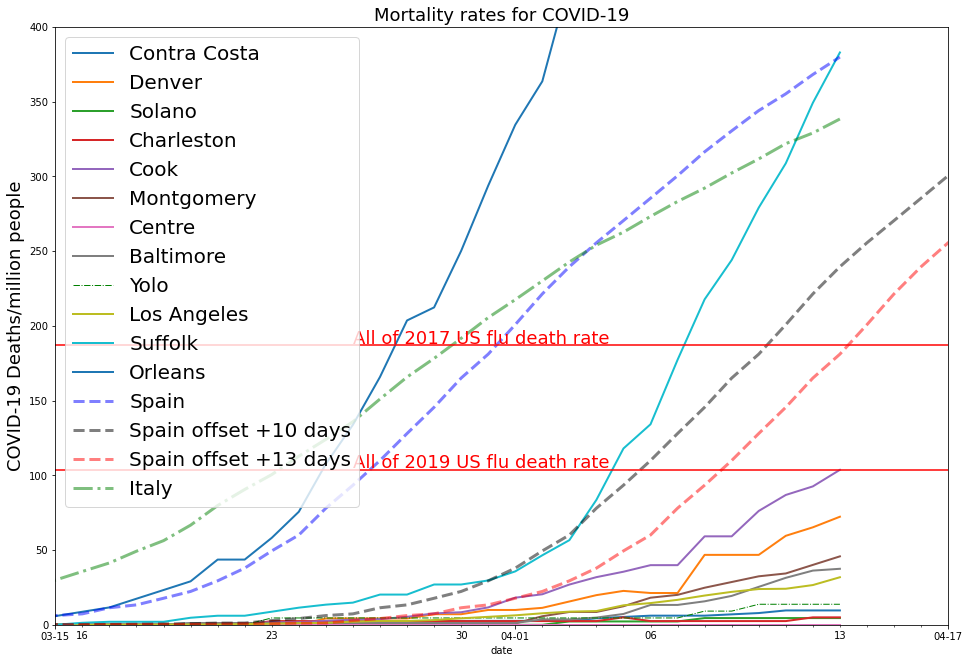

In [4]:

################## make figure ###############
fig = P.figure(figsize=(16,11)) # create a figure object
#fig = P.figure() # create a figure object
ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure


line_w = 2
CC_deaths.plot(kind='line',ax=ax,lw=line_w)
#"""
denver_deaths.plot(kind='line',ax=ax,lw=line_w)
solano_deaths.plot(kind='line',ax=ax,lw=line_w)
SC_deaths.plot(kind='line',ax=ax,lw=line_w)
Chi_deaths.plot(kind='line',ax=ax,lw=line_w)
Mont_deaths.plot(kind='line',ax=ax,lw=line_w)
centre_deaths.plot(kind='line',ax=ax,lw=line_w)
baltimore_deaths.plot(kind='line',ax=ax,lw=line_w)
yolo_deaths.plot(kind='line',ax=ax,lw=1,ls="-.",color='g')
LA_deaths.plot(kind='line',ax=ax,lw=line_w)
suffolk_deaths.plot(kind='line',ax=ax,lw=line_w)
NO_deaths.plot(kind='line',ax=ax,lw=line_w)
espania_deaths_RT.plot(kind='line',ax=ax,lw=3,ls='--',color='b',alpha=0.5)
espania_deaths.plot(kind='line',ax=ax,lw=3,ls='--',color='k',alpha=0.5)
espania_deaths14.plot(kind='line',ax=ax,lw=3,ls='--',color='r',alpha=0.5)
italy_deaths_RT.plot(kind='line',ax=ax,lw=3,ls='-.',color='g',alpha=0.5)
# add flu death comparison
P.axhline(y=us_flu_deaths_per_million_19, color='r', linestyle='-')
P.text('3/26/2020',105,"All of 2019 US flu death rate",color='r',fontsize=18)
P.axhline(y=us_flu_deaths_per_million_17, color='r', linestyle='-')
P.text('3/26/2020',188,"All of 2017 US flu death rate",color='r',fontsize=18)

ax.set_title("Mortality rates for COVID-19",fontsize=18)
ax.set_ylabel("COVID-19 Deaths/million people",fontsize=18)

today = datetime.now()

P.xlim('3/15/20',today + timedelta(days=3)) # Adding 3 days in the future to add predictions
P.ylim(0,400)
#P.ylim(0,50)

# Define the date format
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
P.legend(prop={'size': 20})
#P.savefig(input_urls.outfile)
#P.show()
#"""

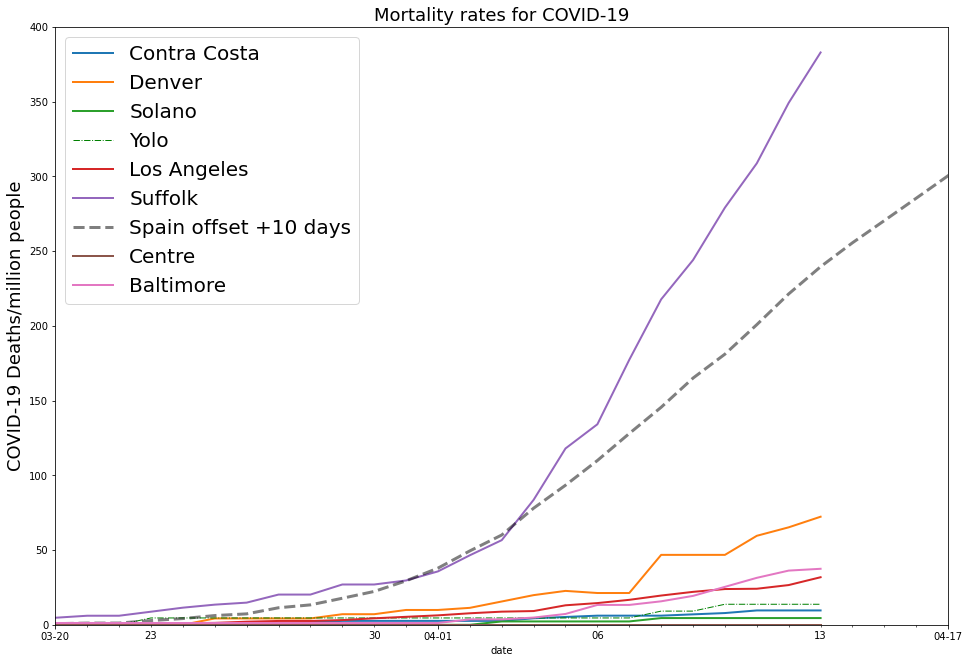

In [8]:

################## make figure ###############
fig = P.figure(figsize=(16,11)) # create a figure object
ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure


line_w = 2
CC_deaths.plot(kind='line',ax=ax,lw=line_w)
denver_deaths.plot(kind='line',ax=ax,lw=line_w)
solano_deaths.plot(kind='line',ax=ax,lw=line_w)

yolo_deaths.plot(kind='line',ax=ax,lw=1,ls="-.",color='g')
LA_deaths.plot(kind='line',ax=ax,lw=line_w)
suffolk_deaths.plot(kind='line',ax=ax,lw=line_w)
espania_deaths.plot(kind='line',ax=ax,lw=3,ls='--',color='k',alpha=0.5)
centre_deaths.plot(kind='line',ax=ax,lw=line_w)
baltimore_deaths.plot(kind='line',ax=ax,lw=line_w)


ax.set_title("Mortality rates for COVID-19",fontsize=18)
ax.set_ylabel("COVID-19 Deaths/million people",fontsize=18)


P.xlim('3/20/20',today + timedelta(days=3))
P.ylim(0,400)
#P.ylim(0,50)

# Define the date format
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
P.legend(prop={'size': 20})


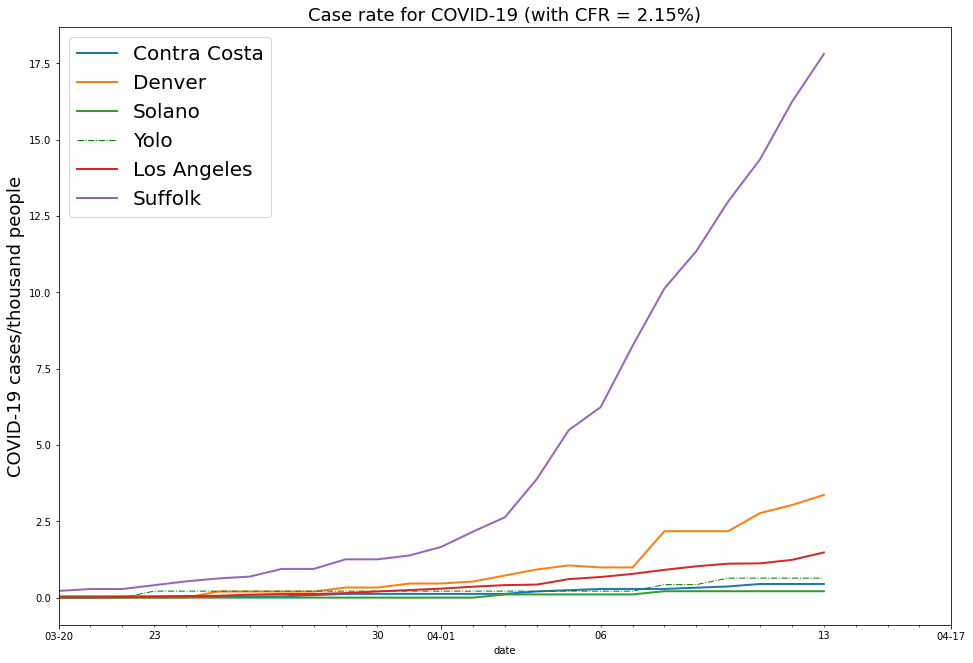

In [9]:

################## make figure ###############
fig = P.figure(figsize=(16,11)) # create a figure object
ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure


line_w = 2
CC_cases.plot(kind='line',ax=ax,lw=line_w)
denver_cases.plot(kind='line',ax=ax,lw=line_w)
solano_cases.plot(kind='line',ax=ax,lw=line_w)

yolo_cases.plot(kind='line',ax=ax,lw=1,ls="-.",color='g')
LA_cases.plot(kind='line',ax=ax,lw=line_w)
suffolk_cases.plot(kind='line',ax=ax,lw=line_w)
#espania_deaths.plot(kind='line',ax=ax,lw=3,ls='--',color='k',alpha=0.5)
#centre_deaths.plot(kind='line',ax=ax,lw=line_w)


ax.set_title("Case rate for COVID-19 (with CFR = 2.15%)",fontsize=18)
ax.set_ylabel("COVID-19 cases/thousand people",fontsize=18)


P.xlim('3/20/20',today + timedelta(days=3))
#P.ylim(0,300)
#P.ylim(0,50)

# Define the date format
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

P.legend(prop={'size': 20})


R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



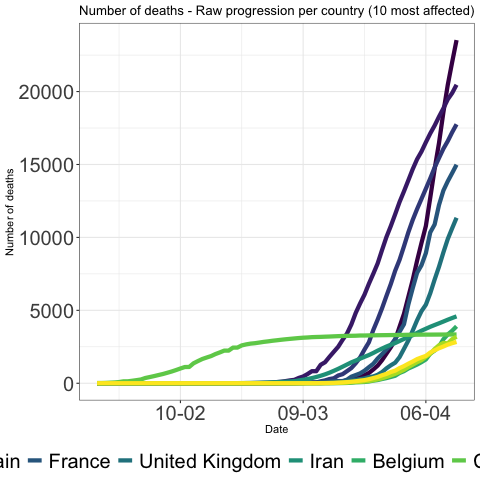

In [7]:
%%R  
# Note: This is a python3 notebook, so you need to run the rpy2 cell (top) before running this. 

#Required libraries
library(RCurl)
library(ggplot2)
library(reshape)

#URL with data
url <- getURL('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
data <- read.csv(text = url,header=F)

#Reshape
#First date is 22 Jan 2020
dates<-as.Date(as.vector(as.matrix(data[1,5:length(data)])), format='%m/%d/%Y')
names(data) <- c('ps','cr','lat','lon',paste('d',1:length(dates),sep=''))  

#Melt and order
datam<-melt(data[-c(1),-c(1,3,4)],id.vars='cr',measure.vars=paste('d',1:length(dates),sep=''))
levels(datam$variable) <- dates
datam$value <- as.numeric(as.character(datam$value))
datamagg <- aggregate(value~cr+variable, datam,'sum')
datamagg$variable<-as.Date(datamagg$variable)
datamagg<-datamagg[order(datamagg$value),]
datamagg$cr <- as.factor(datamagg$cr)
datamagg$cr<-droplevels(datamagg$cr)

#Derive total number of cases for ordering plots
sumcases <- aggregate(value~cr, datamagg[which(as.Date(datamagg$variable)==as.Date(format(Sys.time(), '%y-%m-%d'))-1),],'sum')
datamagg$cr<-factor(datamagg$cr,levels=levels(datamagg$cr)[order(sumcases$value,decreasing=T)],ordered=T)

#Select 10 countries with the highest number of deaths 
datamagg<-datamagg[which(datamagg$cr%in%levels(datamagg$cr)[1:10]),]

#Trend overview
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 300)
#X11(width=20,height=11)

ggplot(datamagg, aes(x=variable, y=value, col=cr)) + 
geom_line(show.legend=TRUE,size=2, linetype=1) +
scale_x_date(date_breaks='4 week',date_labels='%d-%m') +
theme_bw() + 
labs(x="Date", y="Number of deaths") +
ggtitle("Number of deaths - Raw progression per country (10 most affected)") +
guides(col=guide_legend("Country",nrow=1)) +
theme(axis.text.y=element_text(size=20),axis.text.x=element_text(size=20),legend.position="bottom", legend.direction="horizontal",legend.text=element_text(size=20))